In [1]:
import xarray as xr
import rasterio as rio
import pandas as pd
from rasterio.plot import show
import matplotlib.pyplot as plt
import glob
from scipy.signal import find_peaks
import numpy as np
import rioxarray
from rasterio.crs import CRS
import os
import re
import time

In [2]:
inDIR = '/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/'

In [3]:
overwrite=True
csv_list = glob.glob(inDIR + '*.csv')
tif_list = glob.glob(inDIR + 'AVHRR_phenophases_*.tif')
if overwrite:
    proc_list = csv_list
else:
    proc_list = [csv for csv in csv_list if not any(re.sub('.csv', '', csv.split('_')[-1]) in tif for tif in tif_list)]
proc_list

['/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/AVHRR_NDVI_timeseries_1982.csv',
 '/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/AVHRR_NDVI_timeseries_1983.csv',
 '/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/AVHRR_NDVI_timeseries_1984.csv',
 '/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/AVHRR_NDVI_timeseries_1985.csv',
 '/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/AVHRR_NDVI_timeseries_1986.csv',
 '/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/AVHRR_NDVI_timeseries_1987.csv',
 '/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/AVHRR_NDVI_timeseries_1988.csv',
 '/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/AVHRR_NDVI_timeseries_1989.csv',
 '/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/AVHRR_NDVI_timeseries_1990.csv',
 '/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/AVHRR_NDVI_timeseries_1991.csv',
 '/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/AVHRR_NDVI_timeseries_1992.csv',
 '/mnt/c/Users/TBGPEA

In [4]:
def pheno_phases(df):
    df_ndvi_avhrr = df.sort_values('time').reset_index()
    #print(df_ndvi_avhrr['latitude'].unique(), df_ndvi_avhrr['longitude'].unique())
    ndvi_max_gap = (df_ndvi_avhrr['NDVI'].isnull() *
                        (df_ndvi_avhrr['NDVI'].isnull().groupby(
                            (df_ndvi_avhrr['NDVI'].isnull() != df_ndvi_avhrr['NDVI'].isnull().shift())
                                .cumsum()).cumcount() + 1)).max()
    try:
        day_ndvi_pk = df_ndvi_avhrr['NDVI_smth2'][90:305].idxmax()
        ndvi_pk = df_ndvi_avhrr['NDVI_smth2'][90:305].max()
        ndvi_base_gu = df_ndvi_avhrr.loc[:day_ndvi_pk, 'NDVI_smth2_dl'].quantile(q=0.025)
        ndvi_base_gd = df_ndvi_avhrr.loc[day_ndvi_pk:, 'NDVI_smth2_dl'].quantile(q=0.025)
        ndvi_amp_max_gu = ndvi_pk - ndvi_base_gu
        ndvi_amp_max_gd = ndvi_pk - ndvi_base_gd
        ndvi_amp_gu = df_ndvi_avhrr['NDVI_smth2'].loc[:day_ndvi_pk] - ndvi_base_gu
        doys_arr = pd.Series(np.ones_like(df_ndvi_avhrr['NDVI_smth2']) * (df_ndvi_avhrr.index + 1))
        doys_arr_gu = doys_arr.loc[:day_ndvi_pk]
        sos = doys_arr_gu.loc[(ndvi_amp_gu.shift(1) < (0.15 * ndvi_amp_max_gu)) &
                           (ndvi_amp_gu > (0.15 * ndvi_amp_max_gu))].idxmax() + 1
        mgu = doys_arr_gu.loc[(ndvi_amp_gu.shift(1) < (0.50 * ndvi_amp_max_gu)) &
                              (ndvi_amp_gu > (0.50 * ndvi_amp_max_gu))].idxmax() + 1
        mat = doys_arr_gu.loc[(ndvi_amp_gu.shift(1) < (0.90 * ndvi_amp_max_gu)) &
                              (ndvi_amp_gu > (0.90 * ndvi_amp_max_gu))].idxmax() + 1
        pos = df_ndvi_avhrr['NDVI_smth2'].idxmax() + 1
        ndvi_amp_gd = df_ndvi_avhrr['NDVI_smth2'].loc[day_ndvi_pk:, ] - ndvi_base_gd
        doys_arr_gd = doys_arr.loc[day_ndvi_pk:]
        sen = doys_arr_gd.loc[(ndvi_amp_gd.shift(1) > (0.90 * ndvi_amp_max_gd)) &
                              (ndvi_amp_gd < (0.90 * ndvi_amp_max_gd))].idxmax() + 1
        mgd = doys_arr_gd.loc[(ndvi_amp_gd.shift(1) > (0.50 * ndvi_amp_max_gd)) &
                              (ndvi_amp_gd < (0.50 * ndvi_amp_max_gd))].idxmax() + 1
        eos = doys_arr_gd.loc[(ndvi_amp_gd.shift(1) > (0.15 * ndvi_amp_max_gd)) &
                              (ndvi_amp_gd < (0.15 * ndvi_amp_max_gd))].idxmax() + 1
        ndvi_gs_mean = df_ndvi_avhrr['NDVI_smth2'][sos:eos].mean()
        pks = find_peaks(df_ndvi_avhrr['NDVI_smth2'], prominence=0.05, distance=10, width=10, height=ndvi_pk*0.5)[0]
        pks = [x for x in pks if (x > mgu) & (x < mgd)]
        num_pks = len(pks)
        if num_pks > 1:
            pos2 = pks[-1]
        else:
            pos2 = np.nan
        return pd.Series(dict(
            YEAR=df['time'].dt.year.unique()[0],
            ndvi_max_gap=ndvi_max_gap,
            ndvi_max=ndvi_pk,
            ndvi_gs_mean=ndvi_gs_mean,
            SOS=sos,
            MGU=mgu,
            MAT=mat,
            POS=pos,
            POS2=pos2,
            SEN=sen,
            MGD=mgd,
            EOS=eos,
            LGU=mat-sos,
            LGS=mgd-mgu,
            LGD=eos-sen,
            LOS=eos-sos,
            num_pks=num_pks))
    except ValueError:
        return pd.Series(dict(
            YEAR=df['time'].dt.year.unique()[0],
            ndvi_max_gap=np.nan,
            ndvi_max=np.nan,
            ndvi_gs_mean=np.nan,
            SOS=np.nan,
            MGU=np.nan,
            MAT=np.nan,
            POS=np.nan,
            POS2=np.nan,
            SEN=np.nan,
            MGD=np.nan,
            EOS=np.nan,
            LGU=np.nan,
            LGS=np.nan,
            LGD=np.nan,
            LOS=np.nan,
            num_pks=np.nan))

In [5]:
for f in proc_list:
    t0 = time.time()
    yr = re.sub('.csv', '', f.split('_')[-1])
    print(yr)
    print('...reading data')
    df = pd.read_csv(f)
    df['time'] = pd.to_datetime(df['time'])
    t1 = time.time()
    print('......data read in ' + str(round(t1-t0, 2)) + ' seconds')
    print('...calculating pheno-phases')
    df_pheno_phases = df.groupby(['latitude', 'longitude']).apply(pheno_phases)
    print('...converting to xarray')
    xr_pheno_phases = df_pheno_phases.to_xarray()
    xr_pheno_phases.rio.set_crs(CRS.from_string('EPSG:4326'), inplace=True)
    print('...saving to disk')
    xr_pheno_phases.rio.to_raster(os.path.join(inDIR, 'AVHRR_phenophases_' + yr + '.tif'))
    t2 = time.time()
    print('......pheno-phases completed in ' + str(round(t2-t1, 2)) + ' seconds')
    print('...creating timeseries xarray')
    ds = df.set_index(['time', 'latitude', 'longitude']).to_xarray()
    ds.rio.set_crs(CRS.from_string('EPSG:4326'), inplace=True)
    ds = ds.rename({'NDVI_smth2': 'NDVI smoothed', 'NDVI_smth2_dl': 'NDVI double logistic'})
    print('...saving to disk')
    ds['NDVI smoothed'].rio.to_raster(os.path.join(inDIR, 'AVHRR_NDVI_smoothed_' + yr + '.tif'))
    ds['NDVI double logistic'].rio.to_raster(os.path.join(inDIR, 'AVHRR_NDVI_logistic_' + yr + '.tif'))
    t3 = time.time()
    print('......timeseries completed in ' + str(round(t3-t2, 2)) + ' seconds')
    print('Total analysis for ' + yr + ' completed in ' + str(round(t3-t0, 2)) + ' seconds \n')

1982
...reading data
......data read in 17.87 seconds
...calculating pheno-phases
...converting to xarray
...saving to disk
......pheno-phases completed in 157.13 seconds
...creating timeseries xarray
...saving to disk
......timeseries completed in 3.91 seconds
Total analysis for 1982 completed in 178.92 seconds 

1983
...reading data
......data read in 17.53 seconds
...calculating pheno-phases
...converting to xarray
...saving to disk
......pheno-phases completed in 154.79 seconds
...creating timeseries xarray
...saving to disk
......timeseries completed in 3.97 seconds
Total analysis for 1983 completed in 176.29 seconds 

1984
...reading data


/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


......data read in 17.41 seconds
...calculating pheno-phases
...converting to xarray
...saving to disk
......pheno-phases completed in 158.58 seconds
...creating timeseries xarray
...saving to disk
......timeseries completed in 4.25 seconds
Total analysis for 1984 completed in 180.24 seconds 

1985
...reading data
......data read in 17.25 seconds
...calculating pheno-phases
...converting to xarray
...saving to disk
......pheno-phases completed in 154.85 seconds
...creating timeseries xarray
...saving to disk
......timeseries completed in 3.78 seconds
Total analysis for 1985 completed in 175.88 seconds 

1986
...reading data
......data read in 17.48 seconds
...calculating pheno-phases
...converting to xarray
...saving to disk
......pheno-phases completed in 157.63 seconds
...creating timeseries xarray
...saving to disk
......timeseries completed in 3.98 seconds
Total analysis for 1986 completed in 179.09 seconds 

1987
...reading data
......data read in 17.43 seconds
...calculating phen

In [15]:
ds['NDVI smoothed'].rio.to_raster(os.path.join(inDIR, 'AVHRR_NDVI_smoothed_' + yr + '.tif'))
ds['NDVI double logistic'].rio.to_raster(os.path.join(inDIR, 'AVHRR_NDVI_logistic_' + yr + '.tif'))

In [7]:
df = pd.read_csv(f)

NameError: name 'f' is not defined

In [6]:
df['time'] = pd.to_datetime(df['time'])

,time,latitude,longitude,NDVI,TIMEOFDAY,QA,MASK,NDVI_smth1,NDVI_smth1_ds,NDVI_smth2,NDVI_smth2_dl
0,1983-01-01,45.224998,-109.974998,0.0,2019-12-30 20:40:48.001098632,16514.0,1.0,0.0,0.0,0.011379,0.050230
1,1983-01-01,45.224998,-109.924995,0.0,2019-12-30 20:40:48.001098632,16514.0,1.0,0.0,0.0,0.000458,0.028679
2,1983-01-01,45.224998,-109.875000,0.0,2019-12-30 20:40:48.001098632,16514.0,1.0,0.0,0.0,0.003329,0.020366
3,1983-01-01,45.224998,-109.824997,0.0,2019-12-30 20:40:48.001098632,16514.0,1.0,0.0,0.0,0.004492,0.017675
4,1983-01-01,45.224998,-109.774994,0.0,2019-12-30 20:40:48.001098632,16514.0,1.0,0.0,0.0,-0.007083,0.022323


In [76]:
def pheno_phases(df):
    df_ndvi_avhrr = df.sort_values('time').reset_index()
    #print(df_ndvi_avhrr['latitude'].unique(), df_ndvi_avhrr['longitude'].unique())
    ndvi_max_gap = (df_ndvi_avhrr['NDVI'].isnull() *
                        (df_ndvi_avhrr['NDVI'].isnull().groupby(
                            (df_ndvi_avhrr['NDVI'].isnull() != df_ndvi_avhrr['NDVI'].isnull().shift())
                                .cumsum()).cumcount() + 1)).max()
    day_ndvi_pk = df_ndvi_avhrr['NDVI_smth2'][90:305].idxmax()
    ndvi_base_gu = df_ndvi_avhrr.loc[:day_ndvi_pk, 'NDVI_smth2_dl'].quantile(q=0.025)
    ndvi_base_gd = df_ndvi_avhrr.loc[day_ndvi_pk:, 'NDVI_smth2_dl'].quantile(q=0.025)
    ndvi_amp_max_gu = df_ndvi_avhrr['NDVI_smth2'][90:305].max() - ndvi_base_gu
    ndvi_amp_max_gd = df_ndvi_avhrr['NDVI_smth2'][90:305].max() - ndvi_base_gd
    #print(day_ndvi_pk)
    ndvi_amp_gu = df_ndvi_avhrr['NDVI_smth2'].loc[:day_ndvi_pk] - ndvi_base_gu
    doys_arr = pd.Series(np.ones_like(df_ndvi_avhrr['NDVI_smth2']) * (df_ndvi_avhrr.index + 1))
    doys_arr_gu = doys_arr.loc[:day_ndvi_pk]
    #print(doys_arr_gu.loc[(ndvi_amp_gu > (0.90 * ndvi_amp_max_gu))])
    sos = doys_arr_gu.loc[(ndvi_amp_gu.shift(1) < (0.15 * ndvi_amp_max_gu)) &
                       (ndvi_amp_gu > (0.15 * ndvi_amp_max_gu))].idxmax() + 1
    mgu = doys_arr_gu.loc[(ndvi_amp_gu.shift(1) < (0.50 * ndvi_amp_max_gu)) &
                          (ndvi_amp_gu > (0.50 * ndvi_amp_max_gu))].idxmax() + 1
    mat = doys_arr_gu.loc[(ndvi_amp_gu.shift(1) < (0.90 * ndvi_amp_max_gu)) &
                          (ndvi_amp_gu > (0.90 * ndvi_amp_max_gu))].idxmax() + 1
    pos = df_ndvi_avhrr['NDVI_smth2'].idxmax() + 1
    ndvi_amp_gd = df_ndvi_avhrr['NDVI_smth2'].loc[day_ndvi_pk:, ] - ndvi_base_gd
    doys_arr_gd = doys_arr.loc[day_ndvi_pk:]
    sen = doys_arr_gd.loc[(ndvi_amp_gd.shift(1) > (0.90 * ndvi_amp_max_gd)) &
                          (ndvi_amp_gd < (0.90 * ndvi_amp_max_gd))].idxmax() + 1
    mgd = doys_arr_gd.loc[(ndvi_amp_gd.shift(1) > (0.50 * ndvi_amp_max_gd)) &
                          (ndvi_amp_gd < (0.50 * ndvi_amp_max_gd))].idxmax() + 1
    eos = doys_arr_gd.loc[(ndvi_amp_gd.shift(1) > (0.15 * ndvi_amp_max_gd)) &
                          (ndvi_amp_gd < (0.15 * ndvi_amp_max_gd))].idxmax() + 1
    pks = find_peaks(df_ndvi_avhrr['NDVI_smth2'], prominence=0.05, width=10)[0]
    pks = [x for x in pks if (x > sos) & (x < eos)]
    num_pks = len(pks)
    if num_pks == 2:
        pos2 = pks[1]
    else:
        pos2 = np.nan
    return pd.Series(dict(
        YEAR=df['time'].dt.year.unique()[0],
        ndvi_max_gap=ndvi_max_gap,
        SOS=sos,
        MGU=mgu,
        MAT=mat,
        POS=pos,
        POS2=pos2,
        SEN=sen,
        MGD=mgd,
        EOS=eos,
        LGU=mat-sos,
        LGS=mgd-mgu,
        LGD=eos-sen,
        LOS=eos-sos,
        num_pks=num_pks))

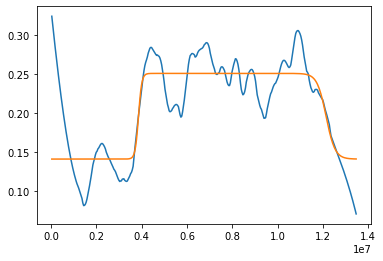

In [43]:
plt.plot(df[(df['latitude'] == 36.02499771118164) & (df['longitude'] == -106.3249969482422)]['NDVI_smth2'])
plt.plot(df[(df['latitude'] == 36.02499771118164) & (df['longitude'] == -106.3249969482422)]['NDVI_smth2_dl'])

In [77]:
#df_sub = 


In [105]:
df_pheno_phases = df.groupby(['latitude', 'longitude']).apply(pheno_phases)
xr_pheno_phases = df_pheno_phases.to_xarray()
xr_pheno_phases.rio.set_crs(CRS.from_string('EPSG:4326'), inplace=True)
xr_pheno_phases.rio.to_raster(os.path.join(inDIR, 'AVHRR_phenophases_1983.tif'))

In [95]:
sub_pheno = df_pheno_phases.iloc[12, :]
sub_df = df[(df['latitude'] == sub_pheno.name[0]) & (df['longitude'] == sub_pheno.name[1])].reset_index()

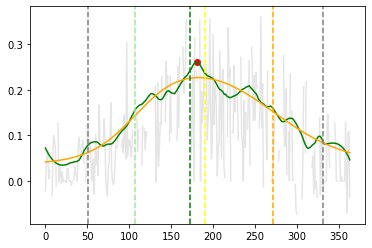

In [96]:
plt.figure()
plt.plot(sub_df['NDVI'], c='grey', alpha=0.2)
plt.plot(sub_df['NDVI_smth2'], c='green')
plt.plot(sub_df['NDVI_smth2_dl'], c='orange')
plt.scatter(x=sub_pheno['POS'],
            y=sub_df['NDVI_smth2'][sub_pheno['POS']], c='red')
if not np.isnan(sub_pheno['POS2']):
    plt.scatter(x=sub_pheno['POS2'],
                y=sub_df['NDVI_smth2'][sub_pheno['POS2']], c='red')
plt.axvline(x=sub_pheno['SOS'], linestyle='dashed', c='grey')
plt.axvline(x=sub_pheno['EOS'], linestyle='dashed', c='grey')
plt.axvline(x=sub_pheno['MGU'], linestyle='dashed', c='lightgreen')
plt.axvline(x=sub_pheno['MAT'], linestyle='dashed', c='green')
plt.axvline(x=sub_pheno['SEN'], linestyle='dashed', c='yellow')
plt.axvline(x=sub_pheno['MGD'], linestyle='dashed', c='orange')

In [84]:
df_pheno_phases.iloc[10, :].name

(36.02499771118164, -109.4749984741211)

In [78]:
import pandas as pd
import dask.dataframe as dd
from dask.multiprocessing import get
ddf = dd.from_pandas(df, npartitions=30)
def apply_pheno_to_DF(data): return data.groupby(['latitude', 'longitude']).apply(pheno_phases)
def pandas_apply(): return apply_pheno_to_DF(df)
def dask_apply(): return ddf.map_partitions(apply_pheno_to_DF).compute(get=get) 

In [80]:
%time
df_pheno_phases2 = pandas_apply()

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.34 µs


In [ ]:
%time
df_pheno_phases2 = pandas_apply()

In [12]:
ds = df.set_index(['time', 'latitude', 'longitude']).to_xarray()

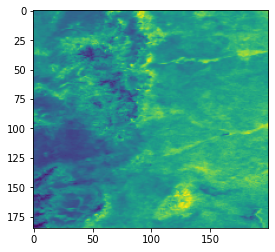

<AxesSubplot:>

In [13]:
show(ds['NDVI_smth2'].mean('time'))

In [25]:
import rioxarray
from rasterio.crs import CRS

In [27]:
ds.rio.set_crs(CRS.from_string('EPSG:4326'), inplace=True)

<xarray.Dataset>
Dimensions:        (time: 364, latitude: 185, longitude: 200)
Coordinates:
  * time           (time) object '1983-01-01' '1983-01-02' ... '1983-12-31'
  * latitude       (latitude) float64 36.02 36.07 36.12 ... 45.12 45.17 45.22
  * longitude      (longitude) float64 -110.0 -109.9 -109.9 ... -100.1 -100.0
Data variables:
    NDVI           (time, latitude, longitude) float64 0.0698 0.0693 ... 0.029
    TIMEOFDAY      (time, latitude, longitude) object '2019-12-30 22:19:11.99...
    QA             (time, latitude, longitude) float64 1.655e+04 ... 1.651e+04
    MASK           (time, latitude, longitude) float64 1.0 1.0 1.0 ... 1.0 1.0
    NDVI_smth1     (time, latitude, longitude) float64 0.0698 0.0693 ... 0.03433
    NDVI_smth1_ds  (time, latitude, longitude) float64 0.0698 0.0693 ... 0.03433
    NDVI_smth2     (time, latitude, longitude) float64 0.1122 0.1202 ... 0.01758
    NDVI_smth2_dl  (time, latitude, longitude) float64 0.07648 ... 0.04417

In [30]:
ds['NDVI_smth2'].rio.to_raster(os.path.join(inDIR, 'AVHRR_NDVI_timeseries_1983.tif'))

In [59]:
df_ndvi_avhrr = ds.isel(latitude=20, longitude=20).to_dataframe().reset_index()

In [68]:
import pandas as pd
import dask.dataframe as dd
from dask.multiprocessing import get

In [70]:
df_ndvi_avhrr['time'] = pd.to_datetime(df_ndvi_avhrr['time'])

In [189]:
def pheno_phases(dat):
    band_list = ['NDVI', 'NDVI_smth2', 'NDVI_smth2_dl']
    
    
    def pheno_phases_np(ndvi_ts, ndvi_smooth, ndvi_dl):
        print(ndvi_ts.shape)
        df_ndvi_avhrr = pd.DataFrame({'NDVI': ndvi_ts,
                                      'NDVI_smth2': ndvi_smooth,
                                      'NDVI_smth2_dl': ndvi_dl})
        display(df_ndvi_avhrr)
        ndvi_max_gap = (df_ndvi_avhrr['NDVI'].isnull() *
                        (df_ndvi_avhrr['NDVI'].isnull().groupby(
                            (df_ndvi_avhrr['NDVI'].isnull() != df_ndvi_avhrr['NDVI'].isnull().shift())
                                .cumsum()).cumcount() + 1)).max()
        day_ndvi_pk = df_ndvi_avhrr['NDVI_smth2'].idxmax()
        ndvi_base_gu = df_ndvi_avhrr.loc[:day_ndvi_pk, 'NDVI_smth2_dl'].quantile(q=0.025)
        ndvi_base_gd = df_ndvi_avhrr.loc[day_ndvi_pk:, 'NDVI_smth2_dl'].quantile(q=0.025)
        ndvi_amp_max_gu = df_ndvi_avhrr['NDVI_smth2'].max() - ndvi_base_gu
        ndvi_amp_max_gd = df_ndvi_avhrr['NDVI_smth2'].max() - ndvi_base_gd
        ndvi_amp_gu = df_ndvi_avhrr['NDVI_smth2'].loc[:day_ndvi_pk] - ndvi_base_gu
        doys_arr = pd.Series(np.ones_like(df_ndvi_avhrr['NDVI_smth2']) * (df_ndvi_avhrr.index + 1))
        doys_arr_gu = doys_arr.loc[:day_ndvi_pk]
        sos = doys_arr_gu.loc[(ndvi_amp_gu.shift(1) < (0.15 * ndvi_amp_max_gu)) &
                           (ndvi_amp_gu > (0.15 * ndvi_amp_max_gu))].idxmax() + 1
        mgu = doys_arr_gu.loc[(ndvi_amp_gu.shift(1) < (0.50 * ndvi_amp_max_gu)) &
                              (ndvi_amp_gu > (0.50 * ndvi_amp_max_gu))].idxmax() + 1
        mat = doys_arr_gu.loc[(ndvi_amp_gu.shift(1) < (0.90 * ndvi_amp_max_gu)) &
                              (ndvi_amp_gu > (0.90 * ndvi_amp_max_gu))].idxmax() + 1
        pos = df_ndvi_avhrr['NDVI_smth2'].idxmax() + 1
        ndvi_amp_gd = df_ndvi_avhrr['NDVI_smth2'].loc[day_ndvi_pk:, ] - ndvi_base_gd
        doys_arr_gd = doys_arr.loc[day_ndvi_pk:]
        sen = doys_arr_gd.loc[(ndvi_amp_gd.shift(1) > (0.90 * ndvi_amp_max_gd)) &
                              (ndvi_amp_gd < (0.90 * ndvi_amp_max_gd))].idxmax() + 1
        mgd = doys_arr_gd.loc[(ndvi_amp_gd.shift(1) > (0.50 * ndvi_amp_max_gd)) &
                              (ndvi_amp_gd < (0.50 * ndvi_amp_max_gd))].idxmax() + 1
        eos = doys_arr_gd.loc[(ndvi_amp_gd.shift(1) > (0.15 * ndvi_amp_max_gd)) &
                              (ndvi_amp_gd < (0.15 * ndvi_amp_max_gd))].idxmax() + 1
        pks = find_peaks(df_ndvi_avhrr['NDVI_smth2'], prominence=500, width=10)[0]
        pks = [x for x in pks if (x > sos) & (x < eos)]
        num_pks = len(pks)
        if num_pks == 2:
            pos2 = pks[1]
        else:
            pos2 = np.nan
        print(num_pks)
        return ndvi_max_gap, sos, mgu, mat, pos, pos2, sen, mgd, eos, mat-sos, mgd-mgu, eos-sen, eos-sos, num_pks

    def pheno_phases_xr(dat_xr, names):
        #dat_xr = dat_xr.stack(z=('latitude', 'longitude'))
        vars_list_xr = []
        for v in band_list:
            vars_list_xr.append(dat_xr[v])
        xr_output = xr.apply_ufunc(pheno_phases_np,
                                         *vars_list_xr,
                                         dask='parallelized',
                                         vectorize=True,
                                         input_core_dims=np.tile(np.array(['time', 'latitude', 'longitude']), (len(band_list), 1)),
                                         output_core_dims=np.repeat(['latitude', 'longitude'], 14),
                                         exclude_dims=set(('time',)),
                                         output_dtypes=np.repeat(['float32'], 14))
        xr_pheno_phases = xr.concat(xr_output, dim='type')#.unstack('z')
        xr_pheno_phases = xr_pheno_phases.assign_coords(type=names)
        return xr_pheno_phases.to_dataset(dim='type')
    
    pheno_phases = pheno_phases_xr(dat, names=['Max NDVI gap','Start of season','Mid-greenup','Maturity',
                                               'Peak of season', 'Peak of season 2',
                                               'Start of sensence','Mid-greendown','End of season',
                                               'Days Green-up','Days Mid-greenup to mid-greendown',
                                               'Days Green-down','Days Growing season',
                                               'Number of peaks'])
    return pheno_phases

In [190]:
test = ds.isel(latitude=slice(20, 25), longitude=slice(20, 25))
test_out = pheno_phases(test)

(364, 5, 5)


ValueError: If using all scalar values, you must pass an index

In [ ]:
df

In [216]:
df_test = ds.isel(latitude=slice(20, 25), longitude=slice(20, 25)).to_dataframe().reset_index()
df_test['time'] = pd.to_datetime(df_test['time'])
#for grp, dat in df_test.groupby(['latitude', 'longitude']):
#    print(grp)
#    print(pheno_phases(dat.reset_index()))

In [206]:
pheno_phases(df_ndvi_avhrr)

(4, 79, 121, 142, 152, nan, 167, 251, 334, 63, 130, 167, 255, 0)

In [208]:
dat
df_ndvi_avhrr

,time,latitude,longitude,NDVI,TIMEOFDAY,QA,MASK,NDVI_smth1,NDVI_smth1_ds,NDVI_smth2,NDVI_smth2_dl
0,1983-01-01,37.024998,-108.974998,NaN,NaN,NaN,NaN,NaN,NaN,0.051461,0.062045
1,1983-01-02,37.024998,-108.974998,0.0998,2019-12-30 22:07:11.996154785,16516.0,1.0,NaN,NaN,0.049070,0.062006
2,1983-01-03,37.024998,-108.974998,0.1108,2019-12-30 21:54:35.999450683,16516.0,1.0,NaN,NaN,0.046975,0.061968
3,1983-01-04,37.024998,-108.974998,0.1046,2019-12-30 21:42:35.996704101,16516.0,1.0,NaN,NaN,0.045165,0.061930
4,1983-01-05,37.024998,-108.974998,0.1057,2019-12-30 21:30:36.000823974,16514.0,1.0,NaN,NaN,0.043630,0.061894
...,...,...,...,...,...,...,...,...,...,...,...
359,1983-12-27,37.024998,-108.974998,0.0954,2019-12-30 23:00:00.000000000,24704.0,1.0,0.095400,0.095400,0.081029,0.077279
360,1983-12-28,37.024998,-108.974998,0.0961,2019-12-30 22:47:59.997253417,16516.0,1.0,0.108495,0.108495,0.084090,0.077091
361,1983-12-29,37.024998,-108.974998,0.1131,2019-12-30 22:35:24.000549316,16516.0,1.0,0.120325,0.120325,0.087568,0.076906
362,1983-12-30,37.024998,-108.974998,NaN,NaN,NaN,NaN,0.127101,0.127101,0.091478,0.076724


In [75]:
from scipy.signal import find_peaks
import numpy as np
yr=1983
#idx=df_ndvi_avhrr.index
ndvi_max_gap = (df_ndvi_avhrr['NDVI'].isnull() *
                    (df_ndvi_avhrr['NDVI'].isnull().groupby(
                        (df_ndvi_avhrr['NDVI'].isnull() != df_ndvi_avhrr['NDVI'].isnull().shift())
                            .cumsum()).cumcount() + 1)).max()
day_ndvi_pk = df_ndvi_avhrr['NDVI_smth2'].idxmax()
ndvi_base_gu = df_ndvi_avhrr.loc[:day_ndvi_pk, 'NDVI_smth2_dl'].quantile(q=0.025)
ndvi_base_gd = df_ndvi_avhrr.loc[day_ndvi_pk:, 'NDVI_smth2_dl'].quantile(q=0.025)
ndvi_amp_max_gu = df_ndvi_avhrr['NDVI_smth2'].max() - ndvi_base_gu
ndvi_amp_max_gd = df_ndvi_avhrr['NDVI_smth2'].max() - ndvi_base_gd
ndvi_amp_gu = df_ndvi_avhrr['NDVI_smth2'].loc[:day_ndvi_pk] - ndvi_base_gu
doys_arr = pd.Series(np.ones_like(df_ndvi_avhrr['NDVI_smth2']) * (df_ndvi_avhrr.index + 1))
doys_arr_gu = doys_arr.loc[:day_ndvi_pk]
sos = doys_arr_gu.loc[(ndvi_amp_gu.shift(1) < (0.15 * ndvi_amp_max_gu)) &
                   (ndvi_amp_gu > (0.15 * ndvi_amp_max_gu))].idxmax() + 1
mgu = doys_arr_gu.loc[(ndvi_amp_gu.shift(1) < (0.50 * ndvi_amp_max_gu)) &
                      (ndvi_amp_gu > (0.50 * ndvi_amp_max_gu))].idxmax() + 1
mat = doys_arr_gu.loc[(ndvi_amp_gu.shift(1) < (0.90 * ndvi_amp_max_gu)) &
                      (ndvi_amp_gu > (0.90 * ndvi_amp_max_gu))].idxmax() + 1
pos = df_ndvi_avhrr['NDVI_smth2'].idxmax() + 1
ndvi_amp_gd = df_ndvi_avhrr['NDVI_smth2'].loc[day_ndvi_pk:, ] - ndvi_base_gd
doys_arr_gd = doys_arr.loc[day_ndvi_pk:]
sen = doys_arr_gd.loc[(ndvi_amp_gd.shift(1) > (0.90 * ndvi_amp_max_gd)) &
                      (ndvi_amp_gd < (0.90 * ndvi_amp_max_gd))].idxmax() + 1
mgd = doys_arr_gd.loc[(ndvi_amp_gd.shift(1) > (0.50 * ndvi_amp_max_gd)) &
                      (ndvi_amp_gd < (0.50 * ndvi_amp_max_gd))].idxmax() + 1
eos = doys_arr_gd.loc[(ndvi_amp_gd.shift(1) > (0.15 * ndvi_amp_max_gd)) &
                      (ndvi_amp_gd < (0.15 * ndvi_amp_max_gd))].idxmax() + 1
pks = find_peaks(df_ndvi_avhrr['NDVI_smth2'], prominence=500, width=10)[0]
pks = [x for x in pks if (x > sos) & (x < eos)]
num_pks = len(pks)
if num_pks == 2:
    pos2 = pks[1]
else:
    pos2 = np.nan
df_pheno_yrly_tmp = pd.DataFrame(dict(
    
    YEAR=df_ndvi_avhrr['time'].dt.year.unique(),
    ndvi_max_gap=ndvi_max_gap,
    SOS=sos,
    MGU=mgu,
    MAT=mat,
    POS=pos,
    POS2=pos2,
    SEN=sen,
    MGD=mgd,
    EOS=eos,
    LGU=mat-sos,
    LGS=mgd-mgu,
    LGD=eos-sen,
    LOS=eos-sos,
    num_pks=num_pks,
), index=[0], dtype='int')
#return df_pheno_yrly_tmp

In [76]:
df_pheno_yrly_tmp

,YEAR,ndvi_max_gap,SOS,MGU,MAT,POS,POS2,SEN,MGD,EOS,LGU,LGS,LGD,LOS,num_pks
0,1983,4,79,121,142,152,NaN,167,251,334,63,130,167,255,0


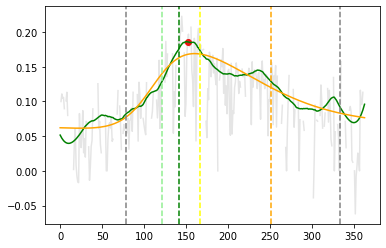

In [67]:
plt.figure()
plt.plot(df_ndvi_avhrr['NDVI'], c='grey', alpha=0.2)
plt.plot(df_ndvi_avhrr['NDVI_smth2'], c='green')
plt.plot(df_ndvi_avhrr['NDVI_smth2_dl'], c='orange')
plt.scatter(x=df_pheno_yrly_tmp['POS'],
            y=df_ndvi_avhrr['NDVI_smth2'][df_pheno_yrly_tmp['POS']], c='red')
plt.axvline(x=df_pheno_yrly_tmp['SOS'].values[0], linestyle='dashed', c='grey')
plt.axvline(x=df_pheno_yrly_tmp['EOS'].values[0], linestyle='dashed', c='grey')
plt.axvline(x=df_pheno_yrly_tmp['MGU'].values[0], linestyle='dashed', c='lightgreen')
plt.axvline(x=df_pheno_yrly_tmp['MAT'].values[0], linestyle='dashed', c='green')
plt.axvline(x=df_pheno_yrly_tmp['SEN'].values[0], linestyle='dashed', c='yellow')
plt.axvline(x=df_pheno_yrly_tmp['MGD'].values[0], linestyle='dashed', c='orange')

[]

In [ ]:
df_pheno_yrly = df_pheno_yrly.append(df_pheno_yrly_tmp)
df_ndvi_avhrr_update = df_ndvi_avhrr_update.append(df_ndvi_avhrr)
if ndvi_max_gap <= 90:
    axs.flatten()[idx].plot(df_ndvi_avhrr['NDVI'], c='grey', alpha=0.5)
    axs.flatten()[idx].plot(df_ndvi_avhrr['NDVI_smth2'], c='orange')
    axs.flatten()[idx].plot(df_ndvi_avhrr['NDVI_smth2_dl'], c='green')
    axs.flatten()[idx].scatter(x=pks, y=df_ndvi_avhrr['NDVI_smth2'][[x + 1 for x in pks]], c='red')
    axs.flatten()[idx].set_title(yr)
else:
    axs.flatten()[idx].set_title(yr)
    continue